In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                         ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [89]:
# Path for exported data, numpy arrays
# Step 4
DATA_PATH = os.path.join('ISL_Data')
actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
# ,,'N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
# 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',

# no of videos
no_sequences = 30

# no of frames in each video
sequence_length = 30

In [90]:
# Step 6 - preprocess data create labels and features
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [91]:
label_map = {label:num for num, label in enumerate(actions)}
#label_map

In [92]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [93]:
X = np.array(sequences)

In [94]:
y = to_categorical(labels).astype(int)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [96]:
X_test.shape

(156, 30, 126)

In [119]:
# Step 7 - build and train lSTM NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [120]:
# Before running this, delete the Logs folder
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [121]:
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv1D, MaxPool1D, Dropout, TimeDistributed, RepeatVector

In [147]:
# CNN Model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(actions.shape[0],activation ="softmax"))

In [149]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [150]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 28, 32)            12128     
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_58 (Conv1D)          (None, 14, 64)            6208      
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_59 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 2, 128)         

In [151]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=500)
#history = model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/500
16/16 [==============================] - 1s 27ms/step - loss: 3.2469 - categorical_accuracy: 0.0581 - val_loss: 3.2459 - val_categorical_accuracy: 0.0320
Epoch 2/500
16/16 [==============================] - 0s 10ms/step - loss: 3.2239 - categorical_accuracy: 0.0461 - val_loss: 3.2171 - val_categorical_accuracy: 0.0560
Epoch 3/500
16/16 [==============================] - 0s 13ms/step - loss: 3.1632 - categorical_accuracy: 0.0641 - val_loss: 3.1085 - val_categorical_accuracy: 0.0960
Epoch 4/500
16/16 [==============================] - 0s 10ms/step - loss: 3.0589 - categorical_accuracy: 0.0902 - val_loss: 2.9902 - val_categorical_accuracy: 0.1280
Epoch 5/500
16/16 [==============================] - 0s 9ms/step - loss: 2.9933 - categorical_accuracy: 0.1042 - val_loss: 2.9121 - val_categorical_accuracy: 0.1360
Epoch 6/500
16/16 [==============================] - 0s 9ms/step - loss: 2.7809 - categorical_accuracy: 0.1804 - val_loss: 2.6698 - val_categorical_accuracy: 0.2640
Epoch 

16/16 [==============================] - 0s 13ms/step - loss: 0.4973 - categorical_accuracy: 0.7976 - val_loss: 0.8867 - val_categorical_accuracy: 0.8160
Epoch 51/500
16/16 [==============================] - 0s 13ms/step - loss: 0.4687 - categorical_accuracy: 0.7996 - val_loss: 1.1332 - val_categorical_accuracy: 0.7520
Epoch 52/500
16/16 [==============================] - 0s 13ms/step - loss: 0.4980 - categorical_accuracy: 0.7836 - val_loss: 0.8730 - val_categorical_accuracy: 0.7680
Epoch 53/500
16/16 [==============================] - 0s 12ms/step - loss: 0.4631 - categorical_accuracy: 0.8196 - val_loss: 1.2190 - val_categorical_accuracy: 0.7600
Epoch 54/500
16/16 [==============================] - 0s 13ms/step - loss: 0.5096 - categorical_accuracy: 0.7796 - val_loss: 1.0831 - val_categorical_accuracy: 0.7280
Epoch 55/500
16/16 [==============================] - 0s 14ms/step - loss: 0.5445 - categorical_accuracy: 0.7756 - val_loss: 1.0583 - val_categorical_accuracy: 0.7520
Epoch 56/50

16/16 [==============================] - 0s 12ms/step - loss: 0.1764 - categorical_accuracy: 0.9379 - val_loss: 1.0459 - val_categorical_accuracy: 0.8560
Epoch 100/500
16/16 [==============================] - 0s 12ms/step - loss: 0.2459 - categorical_accuracy: 0.9158 - val_loss: 1.0738 - val_categorical_accuracy: 0.7920
Epoch 101/500
16/16 [==============================] - 0s 12ms/step - loss: 0.2672 - categorical_accuracy: 0.8998 - val_loss: 0.9188 - val_categorical_accuracy: 0.8320
Epoch 102/500
16/16 [==============================] - 0s 12ms/step - loss: 0.2197 - categorical_accuracy: 0.9198 - val_loss: 1.0519 - val_categorical_accuracy: 0.8400
Epoch 103/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1732 - categorical_accuracy: 0.9459 - val_loss: 1.0610 - val_categorical_accuracy: 0.8480
Epoch 104/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1954 - categorical_accuracy: 0.9259 - val_loss: 1.0914 - val_categorical_accuracy: 0.8400
Epoch 

Epoch 148/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1685 - categorical_accuracy: 0.9439 - val_loss: 1.1454 - val_categorical_accuracy: 0.8320
Epoch 149/500
16/16 [==============================] - 0s 12ms/step - loss: 0.2748 - categorical_accuracy: 0.9178 - val_loss: 1.1111 - val_categorical_accuracy: 0.8480
Epoch 150/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1961 - categorical_accuracy: 0.9419 - val_loss: 1.4888 - val_categorical_accuracy: 0.8320
Epoch 151/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1655 - categorical_accuracy: 0.9479 - val_loss: 0.9456 - val_categorical_accuracy: 0.8800
Epoch 152/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1038 - categorical_accuracy: 0.9579 - val_loss: 1.3358 - val_categorical_accuracy: 0.8720
Epoch 153/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0960 - categorical_accuracy: 0.9699 - val_loss: 1.4032 - val_categorical_accuracy:

Epoch 197/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0858 - categorical_accuracy: 0.9679 - val_loss: 1.2004 - val_categorical_accuracy: 0.8640
Epoch 198/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0896 - categorical_accuracy: 0.9699 - val_loss: 1.5693 - val_categorical_accuracy: 0.8400
Epoch 199/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1070 - categorical_accuracy: 0.9599 - val_loss: 1.7229 - val_categorical_accuracy: 0.8400
Epoch 200/500
16/16 [==============================] - 1s 33ms/step - loss: 0.1166 - categorical_accuracy: 0.9599 - val_loss: 1.2480 - val_categorical_accuracy: 0.8720
Epoch 201/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0978 - categorical_accuracy: 0.9619 - val_loss: 1.3957 - val_categorical_accuracy: 0.8400
Epoch 202/500
16/16 [==============================] - 0s 11ms/step - loss: 0.0745 - categorical_accuracy: 0.9719 - val_loss: 1.2409 - val_categorical_accuracy:

Epoch 246/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0532 - categorical_accuracy: 0.9820 - val_loss: 1.7871 - val_categorical_accuracy: 0.8800
Epoch 247/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0474 - categorical_accuracy: 0.9880 - val_loss: 1.9820 - val_categorical_accuracy: 0.8480
Epoch 248/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0373 - categorical_accuracy: 0.9780 - val_loss: 2.0159 - val_categorical_accuracy: 0.8560
Epoch 249/500
16/16 [==============================] - 0s 15ms/step - loss: 0.0614 - categorical_accuracy: 0.9780 - val_loss: 1.4182 - val_categorical_accuracy: 0.8800
Epoch 250/500
16/16 [==============================] - 0s 14ms/step - loss: 0.0586 - categorical_accuracy: 0.9780 - val_loss: 1.2149 - val_categorical_accuracy: 0.9040
Epoch 251/500
16/16 [==============================] - 0s 16ms/step - loss: 0.0493 - categorical_accuracy: 0.9820 - val_loss: 1.1646 - val_categorical_accuracy:

Epoch 295/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0981 - categorical_accuracy: 0.9659 - val_loss: 1.4867 - val_categorical_accuracy: 0.8480
Epoch 296/500
16/16 [==============================] - 0s 14ms/step - loss: 0.1337 - categorical_accuracy: 0.9579 - val_loss: 1.3500 - val_categorical_accuracy: 0.8480
Epoch 297/500
16/16 [==============================] - 0s 13ms/step - loss: 0.2367 - categorical_accuracy: 0.9459 - val_loss: 1.3686 - val_categorical_accuracy: 0.8320
Epoch 298/500
16/16 [==============================] - 0s 14ms/step - loss: 0.0974 - categorical_accuracy: 0.9739 - val_loss: 1.7176 - val_categorical_accuracy: 0.8400
Epoch 299/500
16/16 [==============================] - 0s 13ms/step - loss: 0.2008 - categorical_accuracy: 0.9599 - val_loss: 1.6819 - val_categorical_accuracy: 0.8160
Epoch 300/500
16/16 [==============================] - 0s 13ms/step - loss: 0.1637 - categorical_accuracy: 0.9619 - val_loss: 1.8944 - val_categorical_accuracy:

Epoch 344/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0306 - categorical_accuracy: 0.9900 - val_loss: 1.4410 - val_categorical_accuracy: 0.8560
Epoch 345/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0369 - categorical_accuracy: 0.9900 - val_loss: 1.6599 - val_categorical_accuracy: 0.8480
Epoch 346/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0434 - categorical_accuracy: 0.9880 - val_loss: 1.6424 - val_categorical_accuracy: 0.8160
Epoch 347/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1764 - categorical_accuracy: 0.9679 - val_loss: 2.1216 - val_categorical_accuracy: 0.7600
Epoch 348/500
16/16 [==============================] - 0s 12ms/step - loss: 0.1819 - categorical_accuracy: 0.9539 - val_loss: 1.8167 - val_categorical_accuracy: 0.8240
Epoch 349/500
16/16 [==============================] - 0s 14ms/step - loss: 0.2206 - categorical_accuracy: 0.9479 - val_loss: 1.2698 - val_categorical_accuracy:

Epoch 393/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0068 - categorical_accuracy: 0.9980 - val_loss: 1.5120 - val_categorical_accuracy: 0.8960
Epoch 394/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0222 - categorical_accuracy: 0.9960 - val_loss: 1.5127 - val_categorical_accuracy: 0.8720
Epoch 395/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0097 - categorical_accuracy: 0.9980 - val_loss: 1.5459 - val_categorical_accuracy: 0.8640
Epoch 396/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0253 - categorical_accuracy: 0.9920 - val_loss: 1.4876 - val_categorical_accuracy: 0.8800
Epoch 397/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0083 - categorical_accuracy: 0.9960 - val_loss: 1.5517 - val_categorical_accuracy: 0.8800
Epoch 398/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0220 - categorical_accuracy: 0.9960 - val_loss: 1.4760 - val_categorical_accuracy:

Epoch 442/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0536 - categorical_accuracy: 0.9900 - val_loss: 1.1102 - val_categorical_accuracy: 0.8800
Epoch 443/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0247 - categorical_accuracy: 0.9960 - val_loss: 1.1436 - val_categorical_accuracy: 0.8880
Epoch 444/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0127 - categorical_accuracy: 1.0000 - val_loss: 0.9790 - val_categorical_accuracy: 0.8960
Epoch 445/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0136 - categorical_accuracy: 0.9980 - val_loss: 0.9953 - val_categorical_accuracy: 0.9120
Epoch 446/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0108 - categorical_accuracy: 0.9960 - val_loss: 1.2043 - val_categorical_accuracy: 0.8960
Epoch 447/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0112 - categorical_accuracy: 0.9980 - val_loss: 1.2021 - val_categorical_accuracy:

Epoch 491/500
16/16 [==============================] - 0s 14ms/step - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 1.1656 - val_categorical_accuracy: 0.8880
Epoch 492/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0096 - categorical_accuracy: 0.9960 - val_loss: 1.1383 - val_categorical_accuracy: 0.8880
Epoch 493/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0088 - categorical_accuracy: 0.9980 - val_loss: 1.0848 - val_categorical_accuracy: 0.8960
Epoch 494/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0116 - categorical_accuracy: 0.9960 - val_loss: 1.0874 - val_categorical_accuracy: 0.8960
Epoch 495/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0041 - categorical_accuracy: 0.9980 - val_loss: 1.0874 - val_categorical_accuracy: 0.8880
Epoch 496/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0158 - categorical_accuracy: 0.9960 - val_loss: 1.1401 - val_categorical_accuracy:

In [152]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [153]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 28, 32)            12128     
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_58 (Conv1D)          (None, 14, 64)            6208      
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_59 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 2, 128)         

In [154]:
len(history.history['categorical_accuracy'])

500

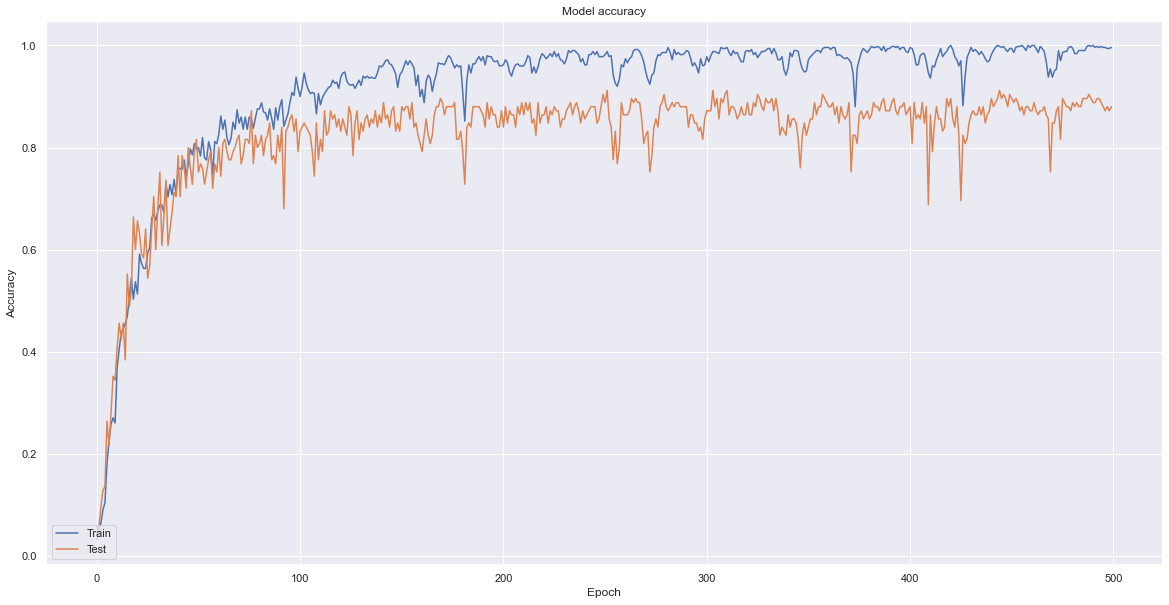

In [155]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()
#plt.savefig('accuracy.pdf', dpi = 700)

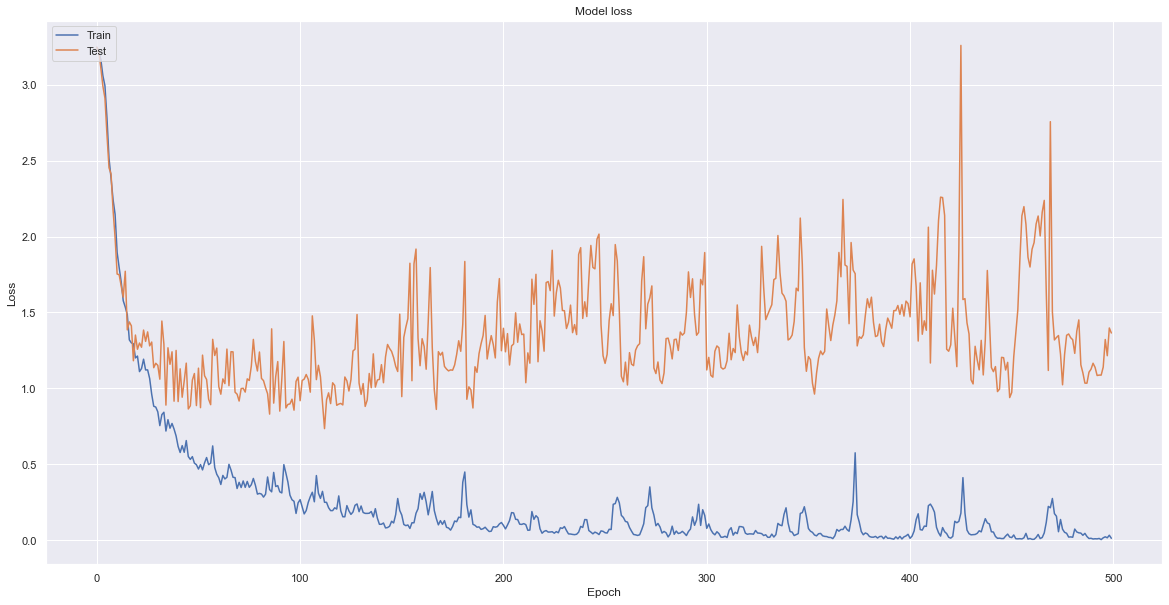

In [156]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#plt.savefig('loss.pdf', dpi = 700)

In [ ]:
! pip install pydot

In [198]:
from tensorflow.keras.utils import plot_model

#model = ResNet50(weights='imagenet')
plot_model(model, to_file='model.pdf', dpi = 700, show_shapes=True)

In [157]:
# Step 8 - Make prediction
res = model.predict(X_test)

In [158]:
actions[np.argmax(res[0])]

'B'

In [159]:
actions[np.argmax(y_test[0])]

'B'

<AxesSubplot:>

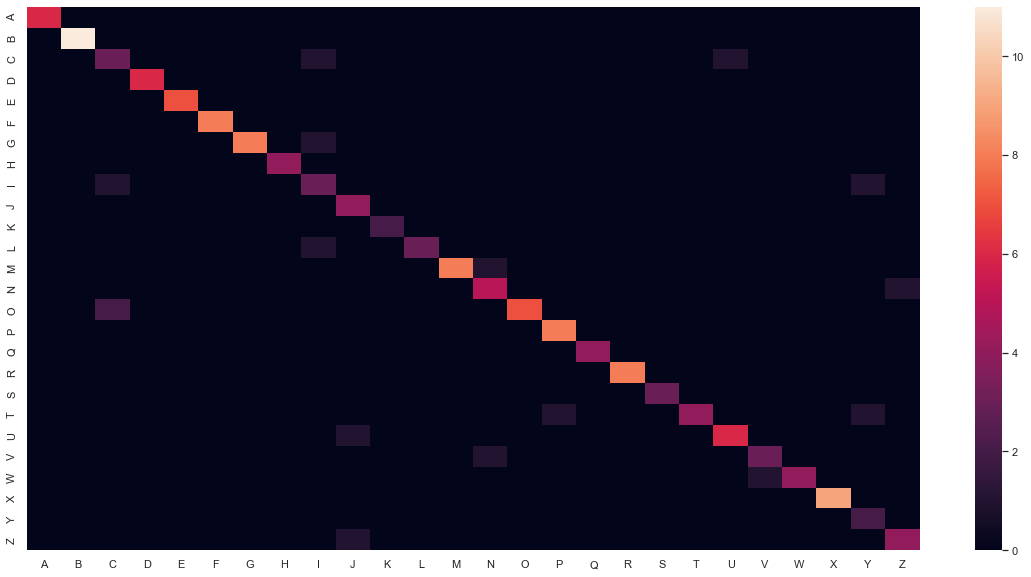

In [160]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score
import seaborn as sns
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

cf_matr = confusion_matrix(ytrue, yhat)
sns.set(rc = {'figure.figsize':(20, 10)})
hmap = sns.heatmap(cf_matr,xticklabels=actions,yticklabels=actions)
hmap
#figure = hmap.get_figure()    
#figure.savefig('Confusion_matrix.pdf', dpi=700)

In [161]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

conf_matrix = multilabel_confusion_matrix(ytrue, yhat)
accuracy_score(ytrue, yhat)

0.8974358974358975

In [162]:
import pandas as pd
import matplotlib.pyplot as plt


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [163]:
actions[12:]

array(['M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U1')

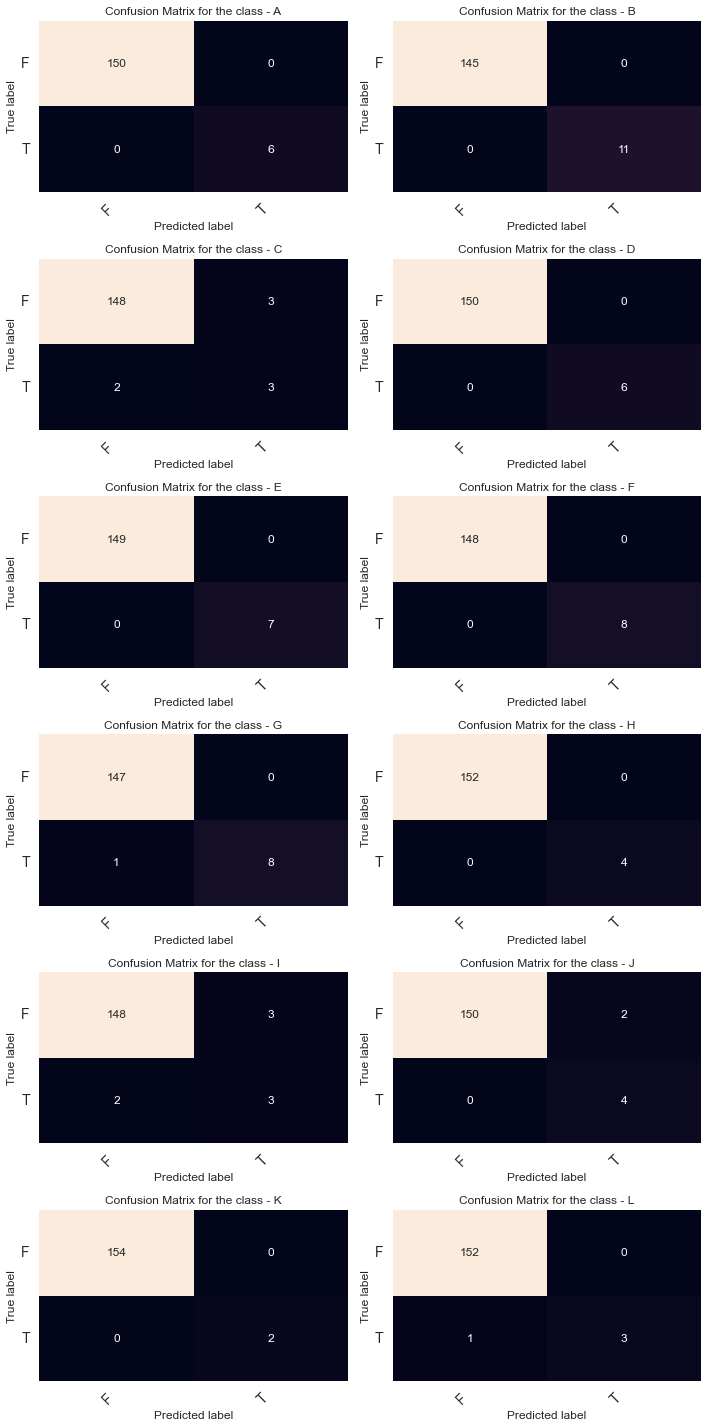

In [164]:
fig, ax = plt.subplots(6, 2, figsize=(10, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[0:12], actions[0:12]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()
#plt.savefig('conf_mat.pdf', dpi = 700)

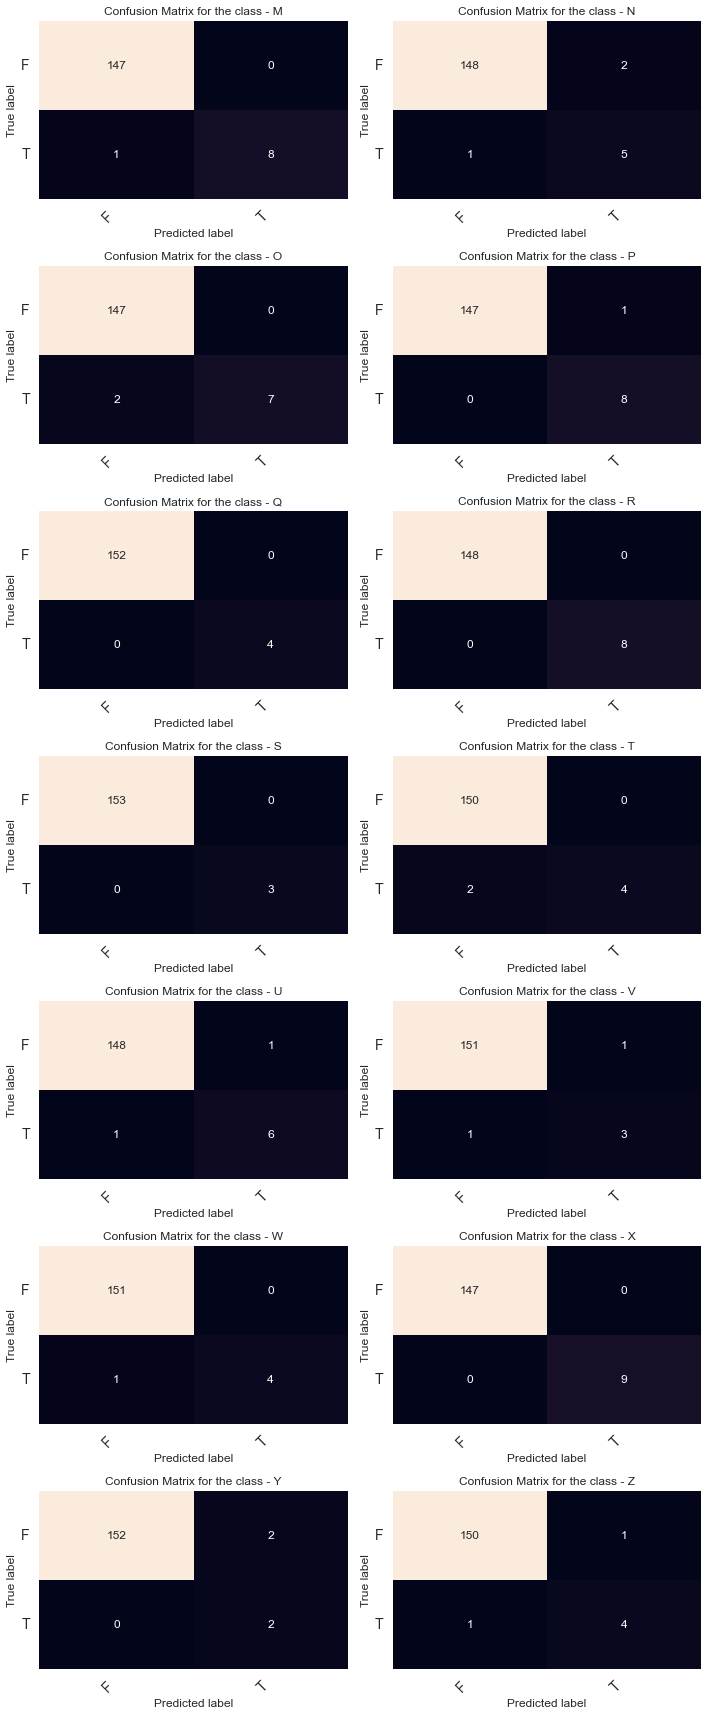

In [165]:
fig, ax = plt.subplots(7, 2, figsize=(10, 24))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix[12:], actions[12:]):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()
#plt.savefig('conf_mat2.pdf', dpi = 700)

In [ ]:
# Uncomment to save your model
model.save('actionA_to_ZNew.h5')

In [166]:
new_actions = np.array(['C', 'O'])
new_label_map = {label:num for num, label in enumerate(new_actions)}
new_label_map

{'C': 0, 'O': 1}

In [167]:
# CNN Model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(new_actions.shape[0],activation ="softmax"))

In [168]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [169]:
sequences, labels = [], []
for action in new_actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(new_label_map[action])

In [170]:
X = np.array(sequences)

In [171]:
y = to_categorical(labels).astype(int)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [173]:
X_train.shape

(42, 30, 126)

In [174]:
y_train.shape

(42, 2)

In [175]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 6ms/step - loss: 0.6958 - categorical_accuracy: 0.4286
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6888 - categorical_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6664 - categorical_accuracy: 0.5476
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6549 - categorical_accuracy: 0.5952
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 0.6568 - categorical_accuracy: 0.5238
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6770 - categorical_accuracy: 0.5238
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6550 - categorical_accuracy: 0.6190
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6318 - categorical_accuracy: 0.7143
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6314 - categorical_accuracy: 0.6190
Epoch 10/100
2/2 [

2/2 [==============================] - 0s 6ms/step - loss: 0.1047 - categorical_accuracy: 0.9524
Epoch 76/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0748 - categorical_accuracy: 0.9524
Epoch 77/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1209 - categorical_accuracy: 0.9048
Epoch 78/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1133 - categorical_accuracy: 0.9048
Epoch 79/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1000 - categorical_accuracy: 0.9762
Epoch 80/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0518 - categorical_accuracy: 1.0000
Epoch 81/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0667 - categorical_accuracy: 0.9762
Epoch 82/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1407 - categorical_accuracy: 0.9524
Epoch 83/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0628 - categorical_accuracy: 0.9762
Epoch 84/100
2/2 [=====

In [176]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 28, 32)            12128     
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 14, 64)            6208      
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_62 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 max_pooling1d_62 (MaxPoolin  (None, 2, 128)         

In [177]:
# Step 8 - Make prediction
res = model.predict(X_test)

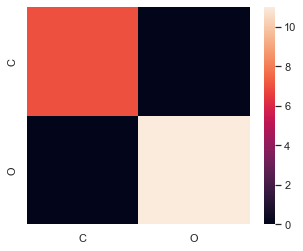

In [178]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

cf_matr2 = confusion_matrix(ytrue, yhat)
sns.set(rc = {'figure.figsize':(5, 4)})
hmap2 = sns.heatmap(cf_matr2,xticklabels=new_actions,yticklabels=new_actions)
hmap2
figure = hmap2.get_figure()    
figure.savefig('Confusion_matrixCO.pdf', dpi=700)

In [180]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(model.predict(X_test), axis=1).tolist()
accuracy_score(ytrue, yhat)

1.0

In [181]:
# Uncomment to save your model
model.save('actionCO.h5')

In [182]:
new_actions = np.array(['M', 'N'])
new_label_map = {label:num for num, label in enumerate(new_actions)}
new_label_map

{'M': 0, 'N': 1}

In [183]:
# CNN Model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 126)))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'valid'))
model.add(MaxPool1D(pool_size=2, strides=None))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(new_actions.shape[0],activation ="softmax"))

In [184]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [185]:
sequences, labels = [], []
for action in new_actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(new_label_map[action])

In [186]:
X = np.array(sequences)

In [187]:
y = to_categorical(labels).astype(int)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [189]:
X_train.shape

(42, 30, 126)

In [190]:
y_train.shape

(42, 2)

In [191]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 5ms/step - loss: 0.6862 - categorical_accuracy: 0.5714
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7104 - categorical_accuracy: 0.5476
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6592 - categorical_accuracy: 0.5238
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6728 - categorical_accuracy: 0.5714
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6847 - categorical_accuracy: 0.5476
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6460 - categorical_accuracy: 0.5476
Epoch 7/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6544 - categorical_accuracy: 0.6190
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6433 - categorical_accuracy: 0.6667
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6092 - categorical_accuracy: 0.6190
Epoch 10/100
2/2 [

2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 75/100
2/2 [==============================] - 0s 8ms/step - loss: 1.4416e-04 - categorical_accuracy: 1.0000
Epoch 76/100
2/2 [==============================] - 0s 9ms/step - loss: 2.0072e-04 - categorical_accuracy: 1.0000
Epoch 77/100
2/2 [==============================] - 0s 10ms/step - loss: 1.8988e-04 - categorical_accuracy: 1.0000
Epoch 78/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 79/100
2/2 [==============================] - 0s 8ms/step - loss: 6.0842e-04 - categorical_accuracy: 1.0000
Epoch 80/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 81/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 82/100
2/2 [==============================] - 0s 9ms/step - loss: 3.7924e-04 - categorical_accuracy: 1.0000
E

In [192]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_63 (Conv1D)          (None, 28, 32)            12128     
                                                                 
 max_pooling1d_63 (MaxPoolin  (None, 14, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_64 (Conv1D)          (None, 14, 64)            6208      
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 7, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 max_pooling1d_65 (MaxPoolin  (None, 2, 128)         

In [193]:
# Step 8 - Make prediction
res = model.predict(X_test)

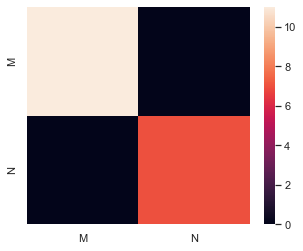

In [194]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

cf_matr3 = confusion_matrix(ytrue, yhat)
sns.set(rc = {'figure.figsize':(5, 4)})
hmap3 = sns.heatmap(cf_matr3,xticklabels=new_actions,yticklabels=new_actions)
hmap3
figure = hmap3.get_figure()    
figure.savefig('Confusion_matrixMN.pdf', dpi=700)

In [195]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(model.predict(X_test), axis=1).tolist()
accuracy_score(ytrue, yhat)

1.0

In [199]:
plot_model(model, to_file='modelCO.pdf', dpi = 700, show_shapes=True)

In [196]:
# Uncomment to save your model
model.save('actionMN.h5')